# Sentiment Analysis on IMDB Movie Reviews using Naïve Bayes Classifier

- Goal: Classify movie reviews as postive or negative
- Dataset: 50,000 IMDB reviews (balanced).
- Model: Naïve Bayes with preprocessing, hyperparameter tuning, and evaluation.
- Reference: https://www.kaggle.com/code/ankumagawa/sentimental-analysis-using-naive-bayes-classifier#4.3.-Tokenization

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import library: 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to C:\Users\Jun
[nltk_data]     Kang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jun
[nltk_data]     Kang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Jun
[nltk_data]     Kang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Import the data:
df=pd.read_csv('data/IMDB_Dataset.csv')

# Understanding the data:
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.describe().T

count unique                                                top  \
review     50000  49582  Loved today's show!!! It was a variety and not...   
sentiment  50000      2                                           positive   

            freq  
review         5  
sentiment  25000

In [6]:
# Sentiment count:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

<Axes: >

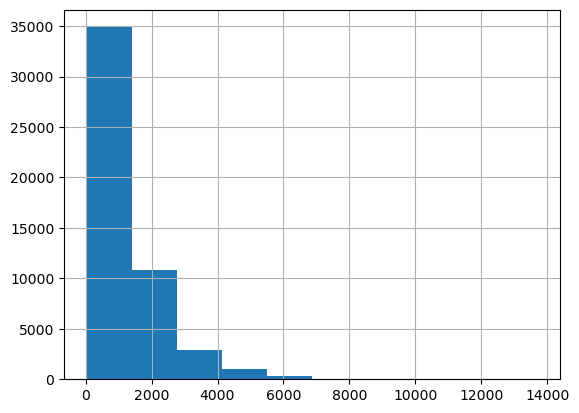

In [7]:
# Our dataset set is balanced. 
# Next, We’ll take a look at the number of characters present in each sentence. 
# This can give us a rough idea about the movie's review.

df['review'].str.len().hist()

Text(0.5, 1.0, 'Negative Reviews')

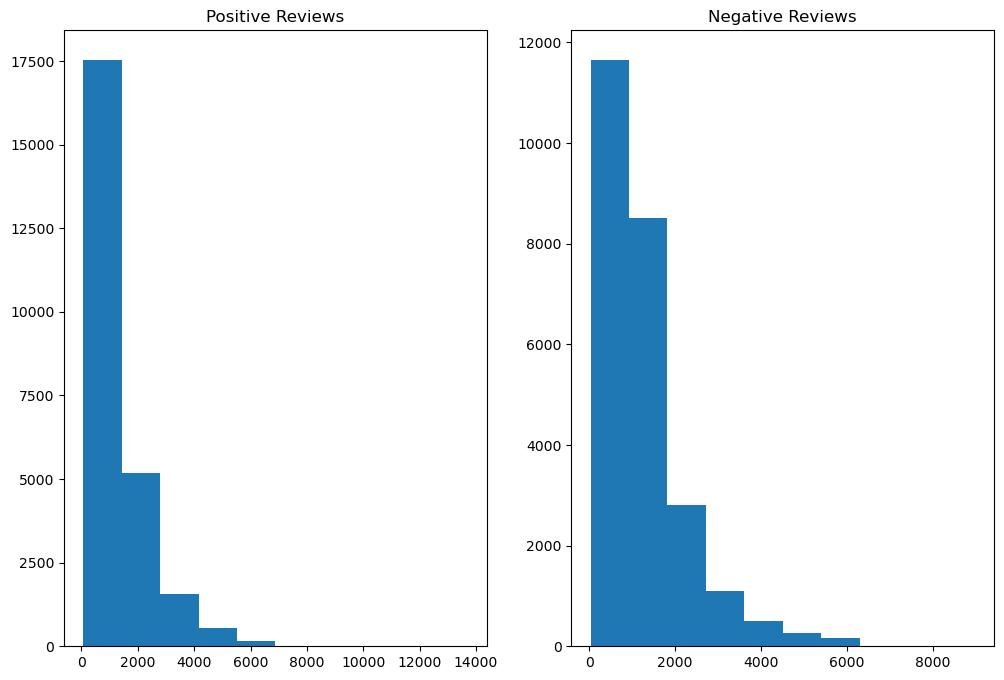

In [8]:
# The histogram shows that reviews range from 10 to 14000 characters and generally, it is between 10 to 1500 characters.
# Now, we will move on the histogram for positive review and negative review respectively.

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
ax1.hist(df[df['sentiment']=='positive']['review'].str.len())
ax1.set_title( 'Positive Reviews')
ax2.hist(df[df['sentiment']=='negative']['review'].str.len())
ax2.set_title( 'Negative Reviews')

we can observe some insights from the graph above:

In general, people comment less word in the positive review to compare with negative review.
However the range of word for positive review are bigger than the range of negative review. It means in some cases, people give a long comments for excellent movies and people could less critise for bad movies

Before we move on to the next section: data preprocessing to clean the text data, we will make a wordcloud graph to show the most used words in large font and the least used words in small font in positive review and negative review

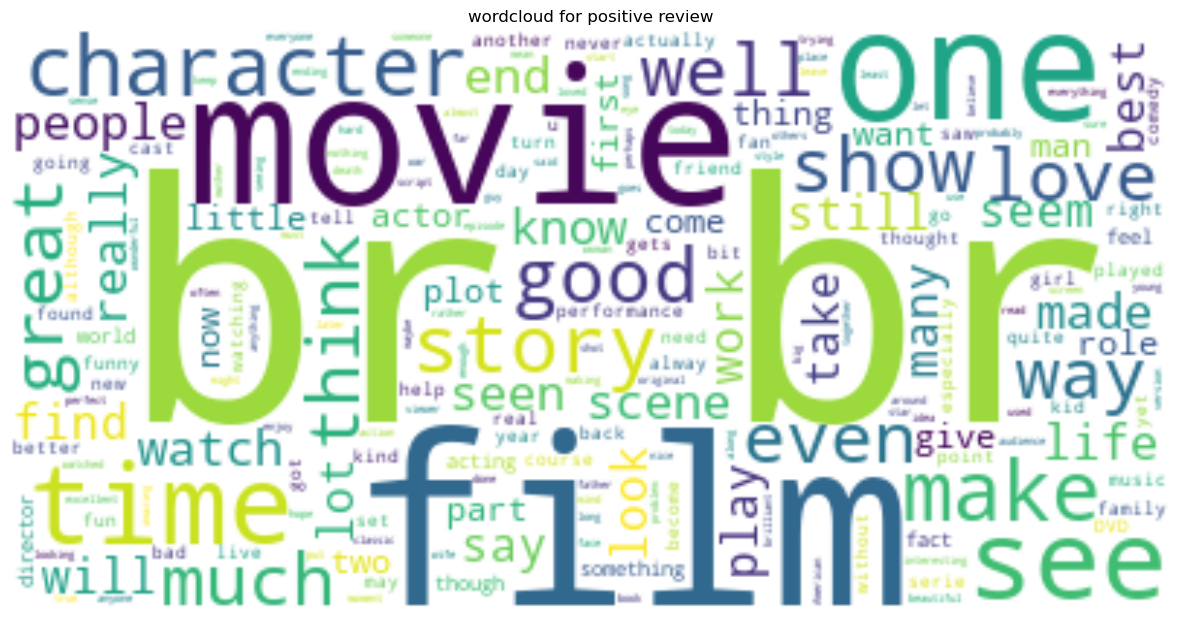

In [9]:
text = " ".join(i for i in df[df['sentiment']=='positive']['review'])
wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for positive review')
plt.show()

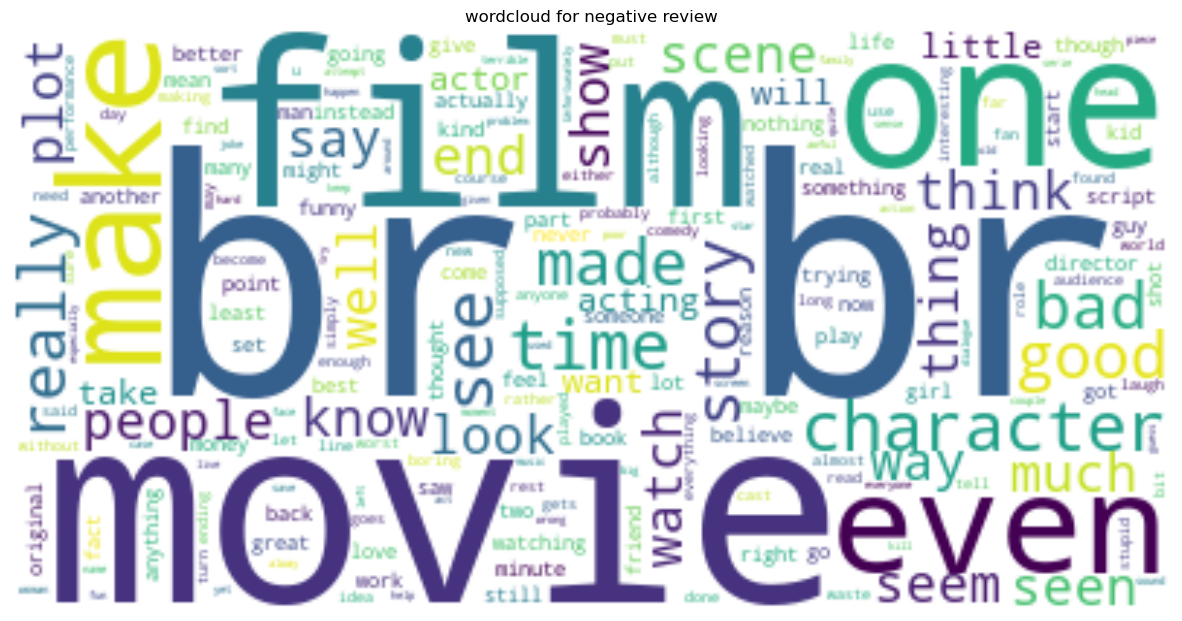

In [10]:
text = " ".join(i for i in df[df['sentiment']=='negative']['review'])
#stopwords = set(STOPWORDS)
wordcloud = WordCloud( background_color="white").generate(text)
#wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for negative review')
plt.show()

The wordcloud graphs in both negative and postitive comments don't show meaningful result.

That's is the reason why text preprosessing is needed.

In [11]:
df.rename(columns={'review':'text'}, inplace = True)
df

text sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]

In [12]:
def cleaning(text):        
    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower() # converting to lowercase
    text = re.sub('https?://\\S+|www\\.\\S+', '', text) # removing URL links
    text = re.sub(r"\b\d+\b", "", text) # removing number 
    text = re.sub('<.*?>+', '', text) # removing special characters, 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # punctuations
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
   
    #removing emoji: 
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)   

   # Contraction map
    contractions = {
        "isn't": "is not",
        "he's": "he is",
        "wasn't": "was not",
        "there's": "there is",
        "couldn't": "could not",
        "won't": "will not",
        "they're": "they are",
        "she's": "she is",
        "wouldn't": "would not",
        "haven't": "have not",
        "that's": "that is",
        "you've": "you have",
        "what's": "what is",
        "weren't": "were not",
        "we're": "we are",
        "hasn't": "has not",
        "you'd": "you would",
        "shouldn't": "should not",
        "let's": "let us",
        "they've": "they have",
        "you'll": "you will",
        "i'm": "i am",
        "we've": "we have",
        "it's": "it is",
        "don't": "do not",
        "that´s": "that is",
        "i´m": "i am",
        "it’s": "it is",
        "she´s": "she is",
        "he’s": "he is",
        "i’m": "i am",
        "i’d": "i did",
        "there’s": "there is",
    }

    # Replace contractions
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text)
    
     
    return text
    
dt = df['text'].apply(cleaning)  

In [13]:
dt = pd.DataFrame(dt)
dt['sentiment']=df['sentiment']
dt

text sentiment
0      one of the other reviewers has mentioned that ...  positive
1      a wonderful little production the filming tech...  positive
2      i thought this was a wonderful way to spend ti...  positive
3      basically theres a family where a little boy j...  negative
4      petter matteis love in the time of money is a ...  positive
...                                                  ...       ...
49995  i thought this movie did a down right good job...  positive
49996  bad plot bad dialogue bad acting idiotic direc...  negative
49997  i am a catholic taught in parochial elementary...  negative
49998  im going to have to disagree with the previous...  negative
49999  no one expects the star trek movies to be high...  negative

[50000 rows x 2 columns]

In [14]:
# remove stop word: 
dt['no_sw'] = dt['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [15]:
dt

text sentiment  \
0      one of the other reviewers has mentioned that ...  positive   
1      a wonderful little production the filming tech...  positive   
2      i thought this was a wonderful way to spend ti...  positive   
3      basically theres a family where a little boy j...  negative   
4      petter matteis love in the time of money is a ...  positive   
...                                                  ...       ...   
49995  i thought this movie did a down right good job...  positive   
49996  bad plot bad dialogue bad acting idiotic direc...  negative   
49997  i am a catholic taught in parochial elementary...  negative   
49998  im going to have to disagree with the previous...  negative   
49999  no one expects the star trek movies to be high...  negative   

                                                   no_sw  
0      one reviewers mentioned watching oz episode yo...  
1      wonderful little production filming technique ...  
2      thought wonderful way spend time hot summer we...  
3      basically theres family little boy jake thinks...  
4      petter matteis love time money visually stunni...  
...                                                  ...  
49995  thought movie right good job wasnt creative or...  
49996  bad plot bad dialogue bad acting idiotic direc...  
49997  catholic taught parochial elementary schools n...  
49998  im going disagree previous comment side maltin...  
49999  one expects star trek movies high art fans exp...  

[50000 rows x 3 columns]

In [16]:
# Working with the most Frequent Words: 
from collections import Counter
cnt = Counter()
for text in dt["no_sw"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']
temp

word  count
0   movie  83576
1    film  74511
2     one  50392
3    like  38833
4    good  28502
5    even  24283
6   would  24001
7    time  23298
8  really  22900
9     see  22437

In [17]:
px.bar(temp, x="count", y="word", title='Commmon Words in Text', orientation='h', 
             width=700, height=700)

In [18]:
# Remove the most frequent words:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
dt["wo_stopfreq"] = dt["no_sw"].apply(lambda text: remove_freqwords(text))
dt.head()

text sentiment  \
0  one of the other reviewers has mentioned that ...  positive   
1  a wonderful little production the filming tech...  positive   
2  i thought this was a wonderful way to spend ti...  positive   
3  basically theres a family where a little boy j...  negative   
4  petter matteis love in the time of money is a ...  positive   

                                               no_sw  \
0  one reviewers mentioned watching oz episode yo...   
1  wonderful little production filming technique ...   
2  thought wonderful way spend time hot summer we...   
3  basically theres family little boy jake thinks...   
4  petter matteis love time money visually stunni...   

                                         wo_stopfreq  
0  reviewers mentioned watching oz episode youll ...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend hot summer weekend...  
3  basically theres family little boy jake thinks...  
4  petter matteis love money visually stunning wa...

In [19]:
dt['no_sw'].loc[5]

'probably alltime favorite movie story selflessness sacrifice dedication noble cause preachy boring never gets old despite seen times last years paul lukas performance brings tears eyes bette davis one truly sympathetic roles delight kids grandma says like dressedup midgets children makes fun watch mothers slow awakening whats happening world roof believable startling dozen thumbs theyd movie'

In [20]:
dt['wo_stopfreq'].loc[5]

'probably alltime favorite story selflessness sacrifice dedication noble cause preachy boring never gets old despite seen times last years paul lukas performance brings tears eyes bette davis truly sympathetic roles delight kids grandma says dressedup midgets children makes fun watch mothers slow awakening whats happening world roof believable startling dozen thumbs theyd'

In [21]:
# Lemmatization: Lemmatization is converting the word to its base form or lemma by removing affixes from the inflected words. 
# It helps to create better features for machine learning and NLP models hence it is an important preprocessing step.


wordnet_lem = WordNetLemmatizer()

dt['wo_stopfreq_lem'] = dt['wo_stopfreq'].apply(wordnet_lem.lemmatize)
dt

text sentiment  \
0      one of the other reviewers has mentioned that ...  positive   
1      a wonderful little production the filming tech...  positive   
2      i thought this was a wonderful way to spend ti...  positive   
3      basically theres a family where a little boy j...  negative   
4      petter matteis love in the time of money is a ...  positive   
...                                                  ...       ...   
49995  i thought this movie did a down right good job...  positive   
49996  bad plot bad dialogue bad acting idiotic direc...  negative   
49997  i am a catholic taught in parochial elementary...  negative   
49998  im going to have to disagree with the previous...  negative   
49999  no one expects the star trek movies to be high...  negative   

                                                   no_sw  \
0      one reviewers mentioned watching oz episode yo...   
1      wonderful little production filming technique ...   
2      thought wonderful way spend time hot summer we...   
3      basically theres family little boy jake thinks...   
4      petter matteis love time money visually stunni...   
...                                                  ...   
49995  thought movie right good job wasnt creative or...   
49996  bad plot bad dialogue bad acting idiotic direc...   
49997  catholic taught parochial elementary schools n...   
49998  im going disagree previous comment side maltin...   
49999  one expects star trek movies high art fans exp...   

                                             wo_stopfreq  \
0      reviewers mentioned watching oz episode youll ...   
1      wonderful little production filming technique ...   
2      thought wonderful way spend hot summer weekend...   
3      basically theres family little boy jake thinks...   
4      petter matteis love money visually stunning wa...   
...                                                  ...   
49995  thought right job wasnt creative original firs...   
49996  bad plot bad dialogue bad acting idiotic direc...   
49997  catholic taught parochial elementary schools n...   
49998  im going disagree previous comment side maltin...   
49999  expects star trek movies high art fans expect ...   

                                         wo_stopfreq_lem  
0      reviewers mentioned watching oz episode youll ...  
1      wonderful little production filming technique ...  
2      thought wonderful way spend hot summer weekend...  
3      basically theres family little boy jake thinks...  
4      petter matteis love money visually stunning wa...  
...                                                  ...  
49995  thought right job wasnt creative original firs...  
49996  bad plot bad dialogue bad acting idiotic direc...  
49997  catholic taught parochial elementary schools n...  
49998  im going disagree previous comment side maltin...  
49999  expects star trek movies high art fans expect ...  

[50000 rows x 5 columns]

Now that the data is cleaned let's implement implement the NB Model

In [22]:
# create the cleaned data for the train-test split:
nb=dt.drop(columns=['text','no_sw', 'wo_stopfreq'])
nb.columns=['sentiment','review']
nb.sentiment = [0 if each == "negative" else 1 for each in nb.sentiment]
nb

sentiment                                             review
0              1  reviewers mentioned watching oz episode youll ...
1              1  wonderful little production filming technique ...
2              1  thought wonderful way spend hot summer weekend...
3              0  basically theres family little boy jake thinks...
4              1  petter matteis love money visually stunning wa...
...          ...                                                ...
49995          1  thought right job wasnt creative original firs...
49996          0  bad plot bad dialogue bad acting idiotic direc...
49997          0  catholic taught parochial elementary schools n...
49998          0  im going disagree previous comment side maltin...
49999          0  expects star trek movies high art fans expect ...

[50000 rows x 2 columns]

In [23]:
# This part usually takes the longest because its trying to find the best hyper parameters to optimize the model with
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# ===== Train-Test Split =====
X_train, X_test, y_train, y_test = train_test_split(nb['review'], nb['sentiment'], test_size=0.10, random_state=42)

# ===== Pipeline =====
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 4),
        max_df=0.7,
        min_df= 2,
        max_features=300000,
        norm='l1',
        smooth_idf=False,
        sublinear_tf=True
    )),
    ('clf', MultinomialNB(
        alpha=0.01,
        fit_prior=True
    ))
])

# ===== Hyperparameter Grid =====
# params = {
#     'tfidf__ngram_range': [(1, 2), (1,3)],  # unigrams + bigrams
#     'tfidf__max_df': [0.7, 0.8],  # ignore extremely common words
#     'tfidf__min_df': [1, 2],  # include most relevant rare words
#     'tfidf__max_features': [150000, 200000],  # more vocab = more info
#     'clf__alpha': [0.01, 0.1, 1.0],
#     'clf__fit_prior': [True, False],
#     'tfidf__norm': ['l1', 'l2', None],
#     'tfidf__smooth_idf': [True, False],
#     'tfidf__sublinear_tf': [True]
# }

# ===== Grid Search =====
# grid = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='accuracy',
# grid.fit(X_train, y_train)

# ==== Looking for Best model ==== 
# best_model = grid.best_estimator_
# print("✅ Best Parameters:", grid.best_params_)

# ==== Model Fitting ==== 
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

# Evaluation
print("\n📊 Classification Report (Multinomial):\n", classification_report(y_test, y_pred))
print("✅ Accuracy:", str(accuracy_score(y_test, y_pred)*100) + "%")


📊 Classification Report (Multinomial):
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      2481
           1       0.90      0.91      0.90      2519

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

✅ Accuracy: 90.18%


In [24]:
import joblib

# Save the best model
joblib.dump(pipeline, 'best_naive_bayes_model.pkl')
print("✅ Model saved!")

✅ Model saved!


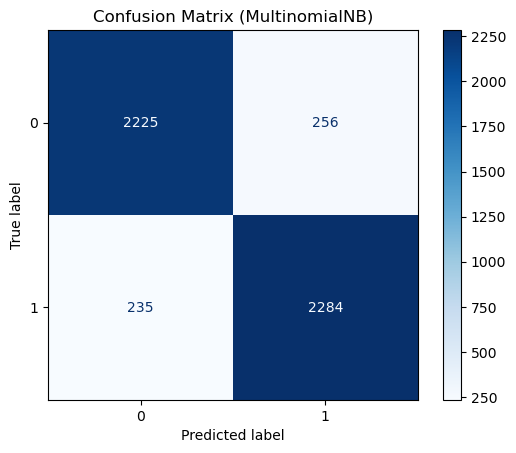

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (MultinomialNB)")
plt.show()

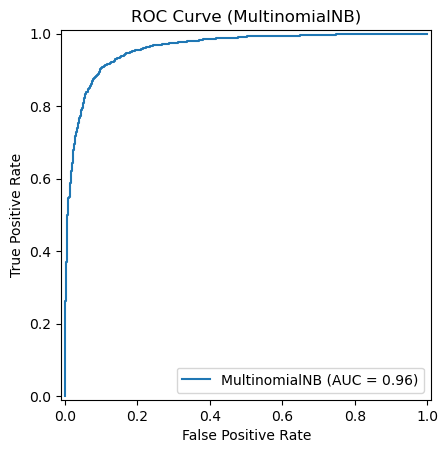

In [26]:
# ROC Curve (for binary classification)
if len(pipeline.classes_) == 2:
    fpr, tpr, _ = roc_curve(y_test.map({pipeline.classes_[1]: 1, pipeline.classes_[0]: 0}), y_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="MultinomialNB").plot()
    plt.title("ROC Curve (MultinomialNB)")
    plt.show()

In [27]:
# Load the saved model
best_model = joblib.load('best_naive_bayes_model.pkl')
print("✅ Model loaded!")

✅ Model loaded!


In [28]:
def predict_sentiment(review):
    review = cleaning(review)
    pred = best_model.predict([review])[0]
    print(f"🔎 Raw model prediction for: {review}")
    if pred == 1:
        return 'Positive'
    else:
        return 'Negative'

print(predict_sentiment("I absolutely loved this movie. It was amazing!"))
print(predict_sentiment("This was the worst film I've ever seen."))

🔎 Raw model prediction for: i absolutely loved this movie it was amazing
Positive
🔎 Raw model prediction for: this was the worst film ive ever seen
Negative
